## Limits of Autoregulation - Summary Statistics

In this notebook we look at the characteristics of the physiologic data when patients move from inside to outside the limits of autoregulation.

#### Useful Imports and Preliminaries

In [1]:
import os
import sys
sys.path.append("..")  # add project root

import h5py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from src.data_utils import *
from src.constants import *

# pending useful sklearn imports
from scipy.stats import pearsonr

In [2]:
pd.options.display.float_format = '{:10,.2f}'.format

In [3]:
plt.rcParams.update({
    'xtick.bottom': True,
    'ytick.left': True
})

In [4]:
np.random.seed(420)

In [5]:
sns.set_theme(context="talk")

In [6]:
# path constants
data_dir = "/home/mr2238/project_pi_np442/mr2238/accelerate/data"
img_dir = "/home/mr2238/project_pi_np442/mr2238/accelerate/imgs/in_out"
global_path = "/home/mr2238/project_pi_np442/mr2238/accelerate/data/processed/all_data.hdf5"
labels_path = os.path.join(data_dir, "labels")
raw_data_path = os.path.join(data_dir, "raw_data")

In [7]:
# check img directory exists, if not make it
os.makedirs(img_dir, exist_ok=True)

In [8]:
# list files
h5py_files = [f for f in os.listdir(raw_data_path) if f.endswith(".icmh5")]
print(f"Number of h5py files: {len(h5py_files)}")
print(f"Example file: {h5py_files[0]}")

Number of h5py files: 215
Example file: 1002.icmh5


### In and Out Statistics

#### Define Limits

Here we explore how much a given patient is within their autoregulatory limits, to get a sense of how to distribute this.
1) Definition: Patient is outside limits of autoregulation if at a given time *t*, the mean ABP value over the minute prior to time *t* is outside the limits calculated at *t*.
2) What do we want?
    - Distribution of % time outside limits: Done
    - Duration of time outside limits: per patient, distribution, median, average
    - Number of times outside limits per patient
    - Correlation between time elapsed and likelihood of being outside of limits: t vs. at time t, what fraction of patients are outside limits?
    - time spent outside autoregulation vs time to autoregulation calc

#### Percent Time In and Out

In [9]:
true_false = {}
ins = []
mode = 'mean'
with h5py.File(global_path, "r") as f:
    for pt in f:
        if f[f"{pt}/processed/in_out_{mode}"].attrs["no_label_overlap"]:
            continue
        in_out_df = pd.Series(f[f"{pt}/processed/in_out_{mode}/in_out"][...]).astype(bool)
        idx_window = pd.DataFrame(f[f"{pt}/processed/in_out_{mode}/window_idx"][...])

        # to actually get percentage of time spent outside autoregulation, we need to get actual window length, we can't weigh all the windows equally
        len_window = idx_window.iloc[:, 1] - idx_window.iloc[:, 0]
        in_out = (in_out_df * len_window).sum() / len_window.sum()
        if len_window.sum() == 0:
            print(pt)
            print(idx_window)
            print(in_out_df)

        true_false[pt] = [in_out]
        ins.append(in_out_df)


In [10]:
true_false_df = pd.DataFrame(true_false).transpose()
bool_in_out_df = pd.concat(ins)
bool_in_out_df.describe()
true_false_df = true_false_df.rename(columns={true_false_df.columns[0]: 'in_percent'})

In [11]:
# calculate percent time in/out per patient, need to switch because in_out is True if in
percent_time = 1- np.array(true_false_df).squeeze()
print(percent_time.shape)

(190,)


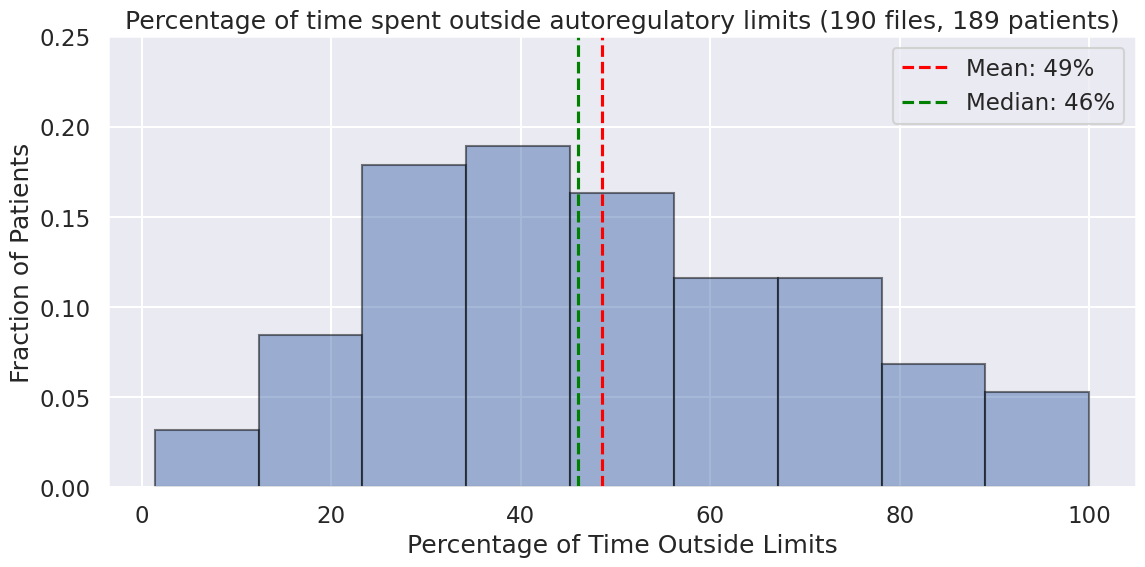

In [12]:
# plot distribtion
fig, ax = plt.subplots(figsize=(12,6))
fig.tight_layout(pad=2)
sns.histplot(percent_time * 100, ax=ax, stat="probability", edgecolor=(0, 0, 0, 0.5), alpha=0.5)
# sns.kdeplot(
#     percent_time / percent_time.sum(),
#     ax=ax,
#     bw_adjust=1,
#     linewidth=2,
#     cut=0,
# )
ax.set_title(f"Percentage of time spent outside autoregulatory limits ({len(percent_time)} files, 189 patients)")
ax.set_xlabel('Percentage of Time Outside Limits')
ax.set_ylabel("Fraction of Patients")
ax.set_ylim(0, 0.25)
ax.set_xticks(np.arange(0, 1, 0.1), minor=True)

mean_value = pd.Series(percent_time).mean()
ax.axvline(x=mean_value * 100, color='red', linestyle='--', label=f'Mean: {mean_value * 100:.0f}%')
ax.legend()

med_value = pd.Series(percent_time).median()
ax.axvline(x=med_value * 100, color='green', linestyle='--', label=f'Median: {med_value * 100:.0f}%')
ax.legend()

img_name = f"in_out_percent_distribution.png"
plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
plt.show()

Now, we can correlate this with the time required to calculate MAP opt.

In [13]:
# load df, find seconds elapsed to calculate opt MAP
with h5py.File(global_path, "r") as f:
    rows = []
    calc = TARGETS
    for pt in f:
        if f[f"{pt}/processed/in_out_{mode}"].attrs["no_label_overlap"]:
            continue
        else:
            time_to_mapopt = find_time_elapsed(str(pt), calc, labels_path, time="s", start_time=int(f[f"{pt}/raw/"].attrs["dataStartTimeUnix"][0]))
            rows.append([time_to_mapopt, str(pt)])
    elapsed_times = pd.DataFrame(rows, columns=['time', 'ptid'])
    elapsed_times_idx = elapsed_times.set_index('ptid').dropna()
    elapsed_times_idx = elapsed_times_idx[elapsed_times_idx > 0]

neg time 597_3, returning 0.
neg time 690_3, returning 0.


In [14]:
# merge dfs
timevpercent = pd.merge(1 - true_false_df, elapsed_times_idx, left_index=True, right_index=True, how='inner')
timevpercent = timevpercent.rename(columns={'in_percent' : 'out_percent'})
timevpercent = timevpercent[timevpercent['time'] > 0]
timevpercent


,out_percent,time
1002,0.38,"8,895.00"
1004,0.42,"3,008.00"
1009,0.17,"12,132.00"
1012,0.19,"16,999.00"
1013,0.58,"3,312.00"
...,...,...
966,0.45,"8,834.00"
969,0.71,"7,396.00"
972,0.81,"6,967.00"
986,0.77,"7,692.00"


In [15]:
x, y = timevpercent["out_percent"], np.log(timevpercent["time"])
r, p = pearsonr(x, y)

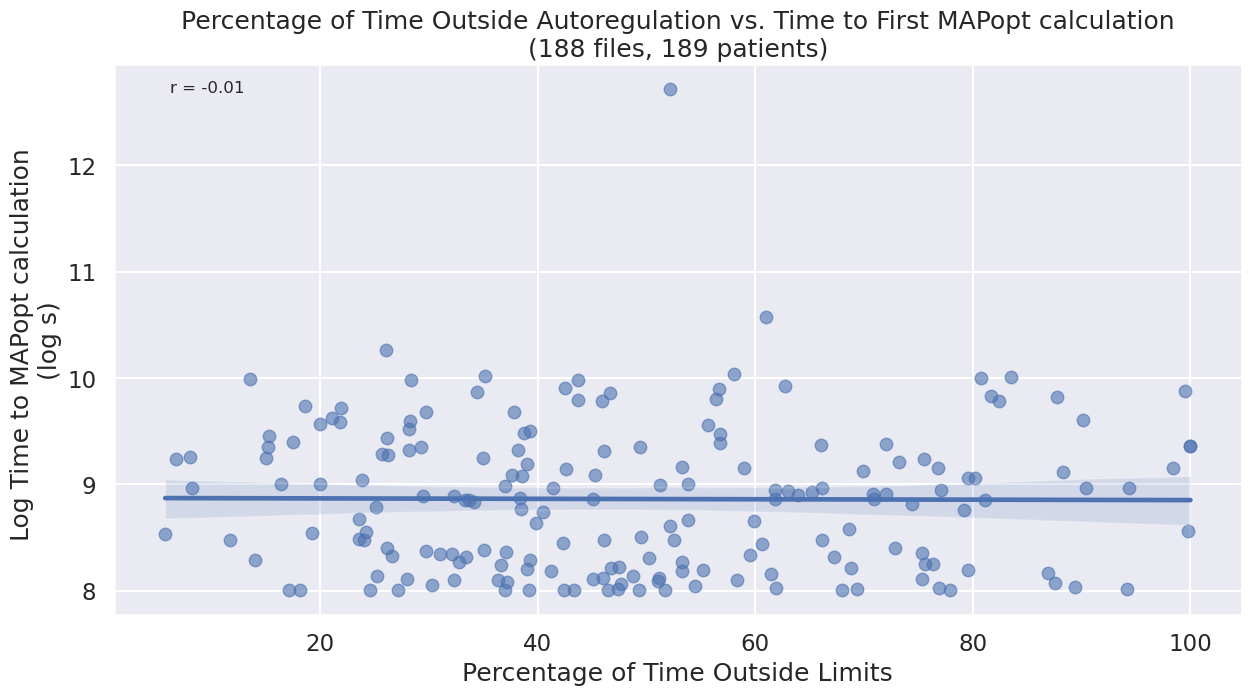

In [16]:
# plot correlation
fig, ax = plt.subplots(figsize=(12,6))
fig.tight_layout(pad=0)
sns.regplot(x = x*100, y = np.log(timevpercent["time"]), scatter_kws={'alpha':0.6})
ax.set_title(f"Percentage of Time Outside Autoregulation vs. Time to First MAPopt calculation\n({timevpercent.shape[0]} files, 189 patients)")
ax.set_xlabel('Percentage of Time Outside Limits')
ax.set_ylabel("Log Time to MAPopt calculation \n(log s)")
# ax.set_ylim(7.5, 11)
# ax.set_xticks(np.arange(0, 1, 0.1), minor=True)

# mean_value = pd.Series(percent_time).mean()
# ax.axvline(x=mean_value * 100, color='red', linestyle='--', label=f'Mean: {mean_value * 100:.0f}%')
# ax.legend()

# med_value = pd.Series(percent_time).median()
# ax.axvline(x=med_value * 100, color='green', linestyle='--', label=f'Median: {med_value * 100:.0f}%')
# ax.legend()
plt.text(0.05, 0.95, f"r = {r:.2f}", transform=plt.gca().transAxes, fontsize=12)

# img_name = f"in_out_percent_distribution.png"
# plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
plt.show()

Notice there is no correlation. Most likely due to the fact that time to MAPopt calc depends on a time period for which there are no autoregulatory limits.

We can also see how the likelihood of being outside the limits is correlated with time elapsed from start of recording.

In [17]:
# get in_out for each patient, add n/a if time index is not represented
# concat and plot
frames = []
with h5py.File(global_path, "r") as f:
    for pt in tqdm(f.keys()):
        processed_data_path = f"{pt}/processed/in_out_{mode}/"
        if f[processed_data_path].attrs["no_label_overlap"]:
            continue
        label_datetimes = pd.to_datetime(f[processed_data_path + "label_timestamp"][...], unit="us", origin="unix")
        zero_idx = label_datetimes - pd.to_datetime((f[f"{pt}/raw"].attrs["dataStartTimeUnix"]).astype(np.int64) * 1e6, unit="us", origin="unix")[0]
        in_out_df = f[f"{pt}/processed/in_out_{mode}/in_out"][...]

        df = pd.DataFrame({
            "timestamp": zero_idx,
            f"in_out_{pt}": 1 - in_out_df
        })
        frames.append(df)

continuous_time_grid = pd.concat(frames, axis=0)
print(continuous_time_grid.shape)
grid_groups = continuous_time_grid.groupby("timestamp", as_index=False)
count_per_timestamp = grid_groups.first()
        

100%|██████████| 192/192 [00:01<00:00, 152.03it/s]


(258542, 191)


/tmp/ipykernel_1915447/1512636936.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  count_per_timestamp = grid_groups.first()


In [18]:
count_per_timestamp['timestamp']

0        0 days 00:01:26
1        0 days 00:02:26
2        0 days 00:03:26
3        0 days 00:04:26
4        0 days 00:05:26
              ...       
76631   13 days 11:42:18
76632   13 days 11:43:18
76633   13 days 11:44:18
76634   13 days 11:45:18
76635   13 days 11:46:18
Name: timestamp, Length: 76636, dtype: timedelta64[ns]

In [19]:
# will do min because that looks better
agg_counts = pd.DataFrame(count_per_timestamp['timestamp'])
agg_counts['sum'] = count_per_timestamp.drop('timestamp', axis = 1).sum(axis=1)
hourly_df = agg_counts.resample('min', on='timestamp').sum()

In [20]:
hourly_df

,sum
timestamp,
0 days 00:01:26,1.00
0 days 00:02:26,1.00
0 days 00:03:26,1.00
0 days 00:04:26,1.00
0 days 00:05:26,1.00
...,...
13 days 11:41:26,1.00
13 days 11:42:26,1.00
13 days 11:43:26,1.00


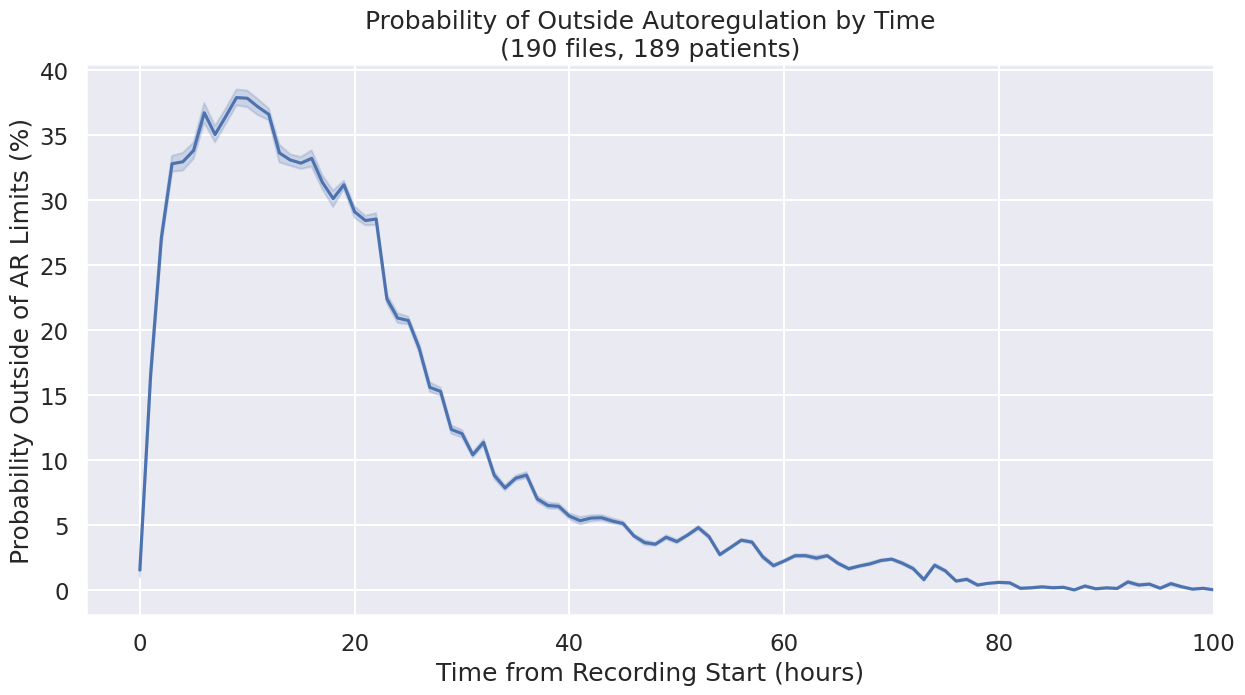

In [21]:
# plot 
fig, ax = plt.subplots(figsize=(12,6))
fig.tight_layout(pad=0)
sns.lineplot(x = hourly_df.index/(1e9*60*60), y = hourly_df['sum']/(count_per_timestamp.shape[1] - 1) * 100)
ax.set_title(f"Probability of Outside Autoregulation by Time\n({count_per_timestamp.shape[1] - 1} files, 189 patients)")
ax.set_xlabel('Time from Recording Start (hours)')
ax.set_ylabel("Probability Outside of AR Limits (%)")

ax.set_xlim(-5, 100)
ax.set_xticks(np.arange(0, 100, 5), minor=True)

img_name = f"in_out_prob_by_time.png"
plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
plt.show()

### Amount of time spent outside of limits

We can do this in one minute intervals, basically develop a function that makes a list of segments of interrupted outside status with their lengths.

In [22]:
minutes_out_per_pt = count_per_timestamp.iloc[:, 1:].sum(axis=0)

In [23]:
minutes_out_per_pt.describe()

count       190.00
mean        640.06
std         545.30
min           6.00
25%         320.50
50%         522.50
75%         788.25
max       3,277.00
dtype: float64

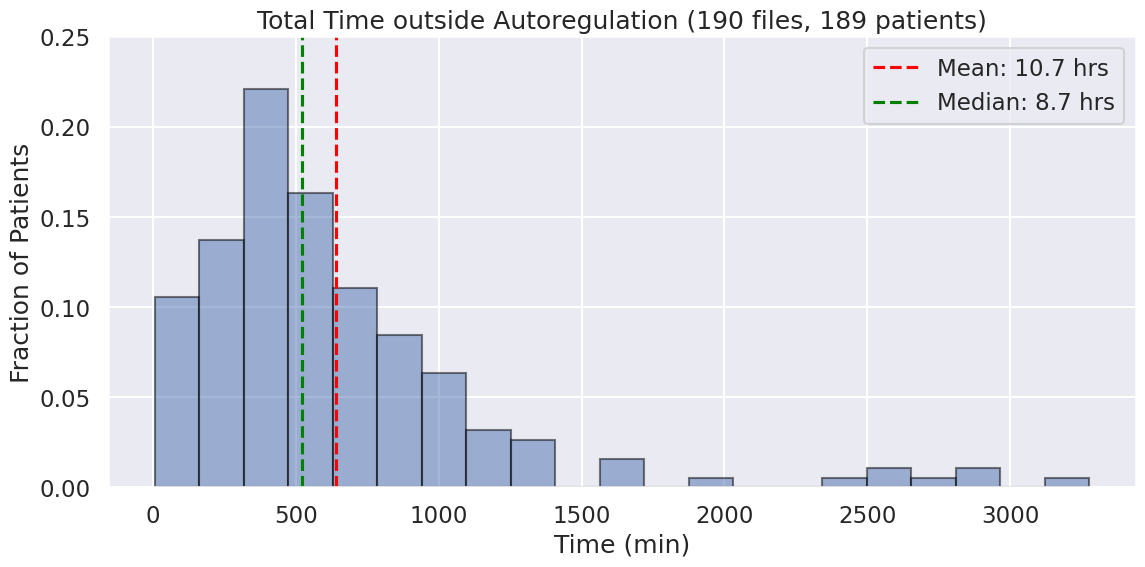

In [24]:
# plot distribution of minutes out
fig, ax = plt.subplots(figsize=(12,6))
fig.tight_layout(pad=2)
sns.histplot(minutes_out_per_pt, ax=ax, stat="probability", edgecolor=(0, 0, 0, 0.5), alpha=0.5,)
ax.set_title(f"Total Time outside Autoregulation ({len(percent_time)} files, 189 patients)")
ax.set_xlabel('Time (min)')
ax.set_ylabel("Fraction of Patients")
ax.set_ylim(0, 0.25)
ax.set_xticks(np.arange(0, 1, 0.1), minor=True)

mean_value = minutes_out_per_pt.mean()
ax.axvline(x=mean_value, color='red', linestyle='--', label=f'Mean: {mean_value/60:.1f} hrs')
ax.legend()

med_value = minutes_out_per_pt.median()
ax.axvline(x=med_value, color='green', linestyle='--', label=f'Median: {med_value/60:.1f} hrs')
ax.legend()

img_name = f"in_out_percent_distribution.png"
# plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
plt.show()

In [25]:
minutes_out_per_pt

in_out_1002        35.00
in_out_1004       109.00
in_out_1009       318.00
in_out_1012       262.00
in_out_1013         7.00
                 ...    
in_out_966        631.00
in_out_969        746.00
in_out_972         90.00
in_out_986        374.00
in_out_993      1,578.00
Length: 190, dtype: float64

In [26]:
# correlate that with time to MAPopt calculation (the longer it takes to calculate, the longer they REMAIN outside limits???)
# there is a wild outlier where it takes more than 60_000 min to compute time so we will remove
# merge time out and minutes_out_per_patient
tmp = minutes_out_per_pt.reset_index()
tmp['index'] = tmp['index'].str.removeprefix('in_out_')
tmp = tmp.set_index('index', drop=True)
tmp = tmp.rename(columns={tmp.columns[0] : "time_out"})
reg_data = pd.merge(tmp, elapsed_times_idx, left_index=True, right_index=True, how='inner').rename(columns={"time" : "time_to_calc"})
filtered = reg_data[reg_data['time_to_calc'] < 60_000]

In [27]:
x, y = filtered["time_to_calc"], filtered["time_out"]
r, p = pearsonr(x, y)

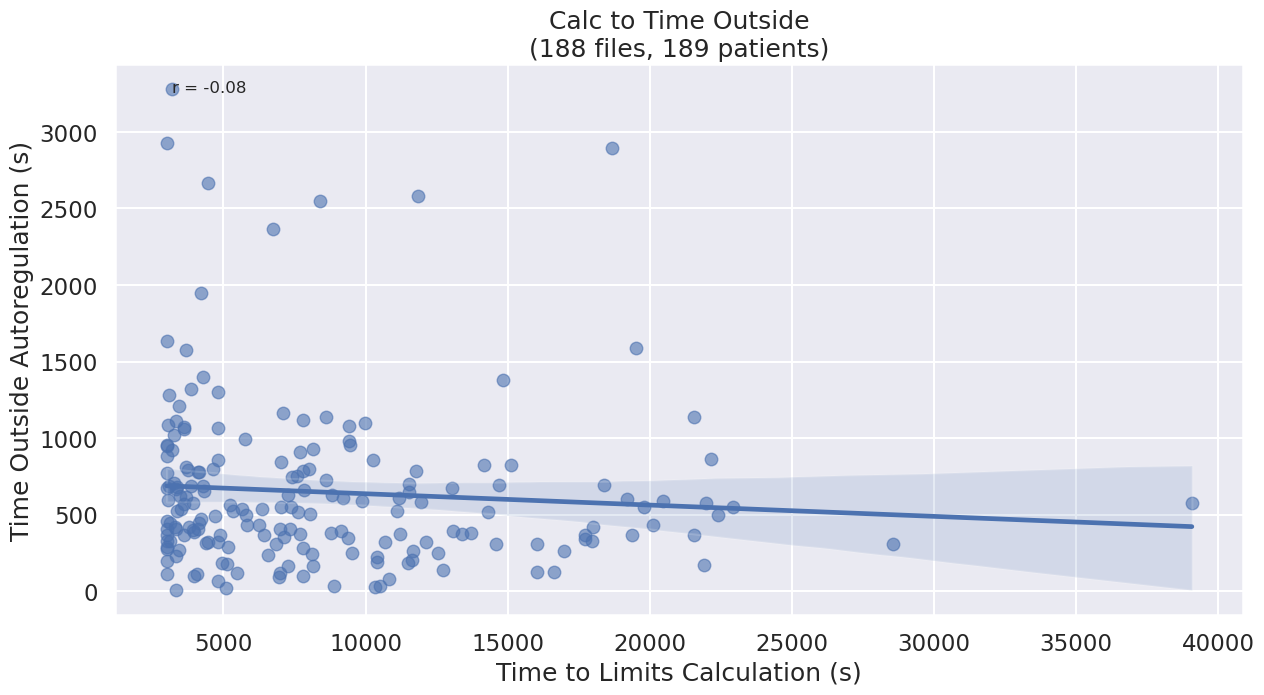

In [28]:
# plot correlation
fig, ax = plt.subplots(figsize=(12,6))
fig.tight_layout(pad=0)
sns.regplot(x = x, y =  y, scatter_kws={'alpha':0.6})
ax.set_title(f"Calc to Time Outside\n({timevpercent.shape[0]} files, 189 patients)")
ax.set_xlabel('Time to Limits Calculation (s)')
ax.set_ylabel("Time Outside Autoregulation (s)")
# ax.set_ylim(7.5, 11)
# ax.set_xticks(np.arange(0, 1, 0.1), minor=True)

# mean_value = pd.Series(percent_time).mean()
# ax.axvline(x=mean_value * 100, color='red', linestyle='--', label=f'Mean: {mean_value * 100:.0f}%')
# ax.legend()

# med_value = pd.Series(percent_time).median()
# ax.axvline(x=med_value * 100, color='green', linestyle='--', label=f'Median: {med_value * 100:.0f}%')
# ax.legend()
plt.text(0.05, 0.95, f"r = {r:.2f}", transform=plt.gca().transAxes, fontsize=12)

# img_name = f"in_out_percent_distribution.png"
# plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
plt.show()

### Segmentation

In [35]:
def get_start_time(g, full_timestamps):
    g_ts = g.index
    t_1 = full_timestamps.get_loc(g_ts[0])
    if t_1 > 0:
        return full_timestamps[t_1 - 1]
    else:
        return full_timestamps[t_1] - (60 * 1e6)

In [ ]:
# now consider continuous segments, plot their average duration, median duration per patient
# correlate that with time to MAPopt calculation (the longer it takes to calculate, the more difficult they are to get out of disruption???)

# loop through each patient's in and out and get the segments
out_time = {}
mode = 'mean'
with h5py.File(global_path, "r") as f:
    for pt in f:
        if f[f"{pt}/processed/in_out_{mode}"].attrs["no_label_overlap"]:
            continue
        out_df = ~(pd.Series(f[f"{pt}/processed/in_out_{mode}/in_out"][...], name = "out?").astype(bool))
        timestamp = pd.Series(f[f"{pt}/processed/in_out_{mode}/label_timestamp"][...], name = "timestamp")
        combined = pd.concat([out_df, timestamp], axis=1)
        combined = combined.set_index('timestamp', drop=True)

        signal = combined['out?']
        change = signal.ne(signal.shift()).cumsum()
        true_groups = (
            combined.groupby(change)
            .filter(lambda g: g['out?'].iloc[0]) # keep only True outs
            .groupby(change)
        )
        intervals = true_groups.apply(
            lambda g: pd.Series({
                'start': pd.to_datetime(get_start_time(g, combined.index), unit='us'),
                'end': pd.to_datetime(g.index[-1], unit='us'),
                'duration': g.index[-1] - get_start_time(g, combined.index)
            })
        )

        out_time[pt] = intervals



In [ ]:
# summary stats of interest
mean = lambda x: out_time[x]['duration'].mean()
median = lambda x: out_time[x]['duration'].median()
stddev = lambda x: out_time[x]['duration'].std()
freq = lambda x, f: out_time[x].shape[0] / int(f[f"{pt}/raw"].attrs['duration'][0].str.removesuffix(' seconds'))

In [ ]:
# calculate stats of interest
with h5py.File(global_path, "r") as f:
    for pt in out_time.keys():
        row = [mean(pt), median(pt), stddev(pt), freq(pt)]
summary_df = pd.DataFrame()

In [ ]:
# TODO: Plot stats
# TODO: correlate with time to MAPopt calc
# TODO: UMAPs?????
# TODO: train/test split

In [ ]:
plt.close()
f.close()